Welcome to our Project 2 Notebook

In [2]:
# Import 3rd party libraries
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler
from requests import get
from functools import reduce

# Configure Notebook
import warnings
warnings.filterwarnings('ignore')

Here we scrape the GoodCarBadCar website to produce tables from which we can form our dataset

In [3]:
years = [2019, 2020, 2021]
ranges = [594, 1, 580]
carsaleslist = []

for index, year in enumerate(years):
    response = get('https://www.goodcarbadcar.net/{year}-canada-vehicle-sales-figures-by-model/' .format(year = year))
    html_soup = BeautifulSoup(response.text, 'html.parser')
    table_rows = html_soup.find_all('tr')[ranges[index]:-1] #excludes the sum row

    model_names = []
    january = []
    february = []
    march = []
    april = []
    may = []
    june = []
    july = []
    august = []
    september = []
    october = []
    november = []
    december = []

    # iterate through each row in the table
    for row in table_rows:
        # use certain tags positions and/or subtags, then extract the text, and use .strip() to remove leading whitespace, and then add them to the corresponding to list
        model_name = row.find_all('td')[0].text.strip()
        model_names.append(model_name)

        jan_sum = row.find_all('td')[1].text.strip()
        january.append(int(jan_sum.replace(',','')))

        feb_sum = row.find_all('td')[2].text.strip()
        february.append(int(feb_sum.replace(',','')))

        mar_sum = row.find_all('td')[3].text.strip()
        march.append(int(mar_sum.replace(',','')))

        apr_sum = row.find_all('td')[4].text.strip()
        april.append(int(apr_sum.replace(',','')))

        may_sum = row.find_all('td')[5].text.strip()
        may.append(int(may_sum.replace(',','')))

        jun_sum = row.find_all('td')[6].text.strip()
        june.append(int(jun_sum.replace(',','')))

        jul_sum = row.find_all('td')[7].text.strip()
        july.append(int(jul_sum.replace(',','')))

        aug_sum = row.find_all('td')[8].text.strip()
        august.append(int(aug_sum.replace(',','')))

        sep_sum = row.find_all('td')[9].text.strip()
        september.append(int(sep_sum.replace(',','')))

        oct_sum = row.find_all('td')[10].text.strip()
        october.append(int(oct_sum.replace(',','')))

        nov_sum = row.find_all('td')[11].text.strip()
        november.append(int(nov_sum.replace(',','')))

        dec_sum = row.find_all('td')[12].text.strip()
        december.append(int(dec_sum.replace(',','')))

    #create a dataframe containing columns corresponding to the lists generated above
    carsaleslist.append(pd.DataFrame({'make_and_model': model_names, '{year}-01-01'.format(year = year): january,
                              '{year}-02-01'.format(year = year): february, '{year}-03-01'.format(year = year): march,'{year}-04-01'.format(year = year): april,
                              '{year}-05-01'.format(year = year):may, '{year}-06-01'.format(year = year):june, '{year}-07-01'.format(year = year):july,'{year}-08-01'.format(year = year):august,
                              '{year}-09-01'.format(year = year): september, '{year}-10-01'.format(year = year): october,
                              '{year}-11-01'.format(year = year): november,'{year}-12-01'.format(year = year): december}).replace("-"," "))
#compile the list of dataframes into a single dataframe, only keeping the makes and models contained in all years
car_sales = reduce(lambda left, right:
               pd.merge(left, right, on = 'make_and_model', how = 'outer'),
               carsaleslist)

Here we merge the Car Model list with the car sales dataframe to allow us to assign a body-type to each of the car models that we have sales data for

In [4]:
'''This section of the code will merge the car_sales data with the car_models data, such that every car make and model
sold will be placed in a car body category'''
#Read the car model csv file containing the body size category of many different car makes and models
car_models = pd.read_csv("Car_Model_List.csv")
#read a hand-generated csv containing the models missing from the main model list but contained in the car_sales dataframe
missing_car_models = pd.read_csv("missing_models.csv")

#create a list of the months considered in this analysis
months_for_analysis = ['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01','2019-07-01',
                       '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
                       '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
                       '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
                       '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
                       '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01']


def make_and_model_canonicalization(car_sales, car_models,missing_car_models):
    '''Canonicalizes car_sales such that the elements in the make_and_model column of both dataframes matches
        input:
        car_sales --> A dataframe containing monthly car sales for different makes and models
        car_models --> A dataframe containing different car makes and models and their body

        returns:
        car_models dataset with modified strings in the make_and_model column to match the car_sales column canonicalization
        car_sales dataset with modified strings in the make_and_model column to match the car_models column canonicalization
        '''
    car_make_list = car_models["Make"].astype(str).str.lower().str.replace("-benz","").unique().tolist()
    # Creating a single column for make and model, to match the format of the car_sales column
    car_models["make_and_model"] = car_models["Make"].astype(str).str.lower() + " " + car_models["Model"].astype(str).str.lower().replace(car_make_list," ",regex=True)

    # Removing duplicates since the same make and model is present for multiple years in the car_models dataframe
    car_models = car_models.loc[:, ["make_and_model", "Category"]].drop_duplicates().apply(lambda x: x.replace("-"," ",regex=True)
                                                                                           .replace("/"," ",regex=True)
                                                                                           .replace("benz"," ",regex=True)
                                                                                           .replace("bolt ev","bolt",regex=True)
                                                                                           .replace("passenger"," ",regex=True)
                                                                                           .replace("crew cab"," ",regex=True)
                                                                                           .replace("extended cab"," ",regex=True)
                                                                                           .replace("regular cab"," ",regex=True)
                                                                                           .replace("1500 double cab"," ",regex=True)
                                                                                           .replace("2500 hd double cab"," ",regex=True)
                                                                                           .replace("2500 cargo"," ",regex=True)
                                                                                           .replace("2500 hd"," ",regex=True)
                                                                                           .replace("3500 hd"," ",regex=True)
                                                                                           .replace("1500"," ",regex=True)
                                                                                           .replace("fuel cell","fcv",regex=True)
                                                                                           .replace("electric"," ",regex=True)
                                                                                           .replace("boxster"," ",regex=True)
                                                                                           .replace("defender 90","defender",regex=True)
                                                                                           .replace("slc class","slc",regex=True))
    car_models["make_and_model"] = car_models["make_and_model"] \
        .apply(lambda x: x[:12] if ("ford transit" in x and "ford transit connect" not in x) else x)\
        .apply(lambda x: "ford f series" if "ford f150" in x else x)\
        .apply(lambda x: "ford e series" if "ford e350" in x else x)

    car_sales["make_and_model"] = car_sales["make_and_model"].str.lower()
    car_models["Category"] = car_models["Category"].replace("1992","",regex=True).replace("2020","",regex=True)

    car_sales = car_sales.apply(lambda x: x.replace("-", " ",regex=True)
                                .replace("/", " ",regex=True)
                                .replace("lr4"," ",regex=True)
                                .replace("impreza wrx","wrx",regex=True)
                                .replace("fr s"," ",regex=True)
                                .replace("benz"," ",regex=True)
                                .replace("etron","e tron",regex=True)
                                .replace("tuscon","tucson",regex=True)
                                .replace("mazda3","mazda 3",regex=True)
                                .replace("mazda6","mazda 6",regex=True)
                                .replace("nautilus"," ",regex=True)
                                .replace("90 series","s90",regex=True)
                                .replace("60 series","s60",regex=True)
                                .replace("40 series","s40",regex=True)
                                .replace("pickup"," ",regex=True)
                                .replace("family"," ",regex=True)
                                .replace("glk class"," ",regex=True)
                                .replace("gl gls class","gls",regex=True)
                                .replace("gle class","gle",regex=True)
                                .replace("slc class","slc",regex=True)
                                .replace("e   cls class","cls",regex=True))

    #Removing additional spaces in the strings in the male_and_model column
    car_sales["make_and_model"] = car_sales["make_and_model"].apply(lambda x:' '.join(x.split()))
    car_models["make_and_model"] = car_models["make_and_model"].apply(lambda x:' '.join(x.split()))
    car_models = pd.concat([car_models, missing_car_models], axis=0)

    return car_sales,car_models

#Merging car_sales and car_models by make and model
car_sales, car_models = make_and_model_canonicalization(car_sales, car_models,missing_car_models)
car_sales_by_size = car_sales.merge(right=car_models,
                                    how='outer',
                                    on='make_and_model')

#Filters out the vehicle makes and models that were not sold in any month from 2019-2021 in Canada
car_sales_by_size = car_sales_by_size[~car_sales_by_size[months_for_analysis].isna().all(1) | (car_sales_by_size[months_for_analysis]==0).all(1)]

#Drop duplicate rows
car_sales_by_size = car_sales_by_size.drop_duplicates(['make_and_model'])

#DEBUGGING: Finding null category values
#car_sales_list = car_sales["make_and_model"].to_list()
#missing_cars = (car_sales_by_size[car_sales_by_size["Category"].isnull()])["make_and_model"].to_list()
#print("Car bodies with null values: \n", missing_cars)
#print("Number of car bodies with null values: ", len(missing_cars))
#print("Car models list:\n", car_models["make_and_model"].to_list())


#put car model, car sales, and merged car sales list  to csv
car_models.to_csv('Car_Model_List_updated.csv', encoding='utf-8', index=False)
car_sales.to_csv('Car_Sales_2019_2021.csv', encoding='utf-8', index=False)
car_sales_by_size.to_csv('Merged Car Sales List.csv', encoding='utf-8', index=False)

#print(car_sales_by_size['Category'].unique())

#####################################################################################################################
#Now combining all the data into one table

#categorizing all combinations of car size category
small_cars=["Coupe","Hatchback","Convertible",'Convertible, Sedan','Coupe, Sedan, Convertible',
            'Coupe, Convertible','Convertible, Sedan, Coupe','Sedan, Hatchback','Hatchback, Sedan',
            'Hatchback, Sedan, Coupe','Convertible, Coupe, Hatchback']
midsize_cars=["SUV","Sedan","Wagon",'Wagon, Sedan']
large_cars=["Pickup","Van","Minivan",'Van Minivan']

#categorizing the sizes
car_sales_by_size['Category'] = car_sales_by_size['Category']\
    .apply(lambda x: 'small' if (x in small_cars) else x)\
    .apply(lambda x: 'midsize' if (x in midsize_cars) else x)\
    .apply(lambda x: 'large' if (x in large_cars) else x)

#create a new dataframe with categorized % columns
car_size_category = car_sales_by_size.groupby('Category').agg(sum)
#print(car_size_category)

#create monthly sums list
monthly_sums = list(car_sales_by_size.sum(axis = 0)[1:-1])

#calculate % proportion sales for each size of car per month
car_size_category = (car_size_category/monthly_sums).T.rename(columns={"small": "prop_small",
                                                                       "midsize": "prop_midsize",
                                                                       "large": "prop_large"})

##sanity check
#car_size_category['total'] = list(car_size_category.sum(axis = 1))
#print(car_size_category)

Here we add all the other features we consider to the dataframe

In [5]:
#convert to datetime index full month name and full year
#car_size_category.index = car_size_category.reset_index()['index'].apply(lambda x: datetime.strptime(x,"%B %Y"))
car_size_category.index = pd.to_datetime(car_size_category.reset_index()['index'])

#create a column for monthly sums
car_size_category['total_sum'] = monthly_sums

car_size_category.to_csv('%_category.csv', encoding='utf-8', index=False)

#monthly employment stats units corrected (x1000) and datetime index set
employment_stats = pd.read_csv("monthly_employment_stats_2019-2021.csv").set_index('Labour force characteristics')\
    .T.astype(str).replace(',','',regex = True).astype(float)
employment_stats.index = employment_stats.reset_index()['index'].apply(lambda x: datetime.strptime(x,"%b-%y"))

employment_stats[['Unemployment rate','Participation rate','Employment rate']]= employment_stats[['Unemployment rate','Participation rate','Employment rate']]/100
employment_stats[employment_stats.columns.difference(['Unemployment rate','Participation rate','Employment rate'])]\
    =employment_stats[employment_stats.columns.difference(['Unemployment rate','Participation rate','Employment rate'])]*1000

#employment_stats.to_csv('monthly_employment_stats_2019-2021_updated.csv', encoding='utf-8', index=False)

#monthly oil prices units corrected (cents to dollars) and datetime index set
oil_prices = pd.read_csv("monthly_oil_prices_2019-2021.csv").rename(columns={"VALUE": "avg_oil_price"})\
                 .set_index('REF_DATE').loc[:,'avg_oil_price'].astype(float)/100
oil_prices.index = oil_prices.reset_index()['REF_DATE'].apply(lambda x: datetime.strptime(x,"%b-%y"))

#oil_prices.to_csv('monthly_oil_prices_2019-2021_updated.csv', encoding='utf-8', index=False)

#monthly transit ridership units corrected (x1 mill) and datetime index set
transit_ridership = pd.read_csv("monthly_transit_ridership_2019-2021.csv").rename(columns={"VALUE": "transit_ridership"})\
                        .set_index('REF_DATE').loc[:,'transit_ridership'].astype(float)*1000000
transit_ridership.index = transit_ridership.reset_index()['REF_DATE'].apply(lambda x: datetime.strptime(x,"%b-%y"))

#transit_ridership.to_csv('monthly_transit_ridership_2019-2021_updated.csv', encoding='utf-8', index=False)

#monthly dollar exchange rate (USD-CAD) datetime index set
der_usd_cad = pd.read_csv("monthly_der_2019-2021.csv").rename(columns={"FXMUSDCAD": "dollar_ex_rate"})\
                        .set_index('date').loc[:,'dollar_ex_rate'].astype(float)
der_usd_cad.index = der_usd_cad.reset_index()['date'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d"))
#print(der_usd_cad)

#monthly gdp (in 2012 dollars) units correct and datetime index set
gdp = pd.read_csv("monthly_oil_prices_2019-2021.csv").rename(columns={"VALUE": "gdp"})\
                 .set_index('REF_DATE').loc[:,'gdp'].astype(float)*1000000
gdp.index = gdp.reset_index()['REF_DATE'].apply(lambda x: datetime.strptime(x,"%b-%y"))

#monthly interest rates
interest_rates = pd.read_csv('monthly_interest_rates_canada.csv')
interest_rates['Date'] = pd.to_datetime(interest_rates['Date'])
interest_rates.set_index('Date', drop = True, inplace= True)

#merging all dataframes into using datetime indices
total_table = pd.concat([car_size_category,employment_stats,oil_prices,transit_ridership, der_usd_cad, gdp, interest_rates], axis=1)
total_table.to_csv('Merged Total Table.csv', encoding='utf-8', index=False)

#####################################################################################################################

#Limiting table to independent variables for analysis and excluding pandemic dates from the beginning of the pandemic
#in March 2020 until December 2020, when there was a 0% change in Canadian GDP and after which GDP stabilized.
#https://www150.statcan.gc.ca/n1/pub/71-607-x/71-607-x2020009-eng.htm
pandemic_dates = pd.to_datetime(["2020-03-01","2020-04-01","2020-05-01","2020-06-01","2020-07-01","2020-08-01"
                                    ,"2020-09-01","2020-10-01","2020-11-01","2020-12-01","2021-01-01","2021-02-01",
                                 "2021-03-01","2021-04-01","2021-05-01","2021-06-01","2021-07-01","2021-08-01"
                                    ,"2021-09-01","2021-10-01","2021-11-01","2021-12-01"])

table_for_data_analysis = total_table.drop(pandemic_dates).reset_index().loc[:,["index","prop_large","prop_midsize"
                                                                                   ,"prop_small","Population"
                                                                                   ,"Employment rate","Full-time employment"
                                                                                   ,"Part-time employment","Unemployment"
                                                                                   ,"avg_oil_price","transit_ridership"
                                                                                   ,"dollar_ex_rate"]]

Here we run some analysis on the data we've included

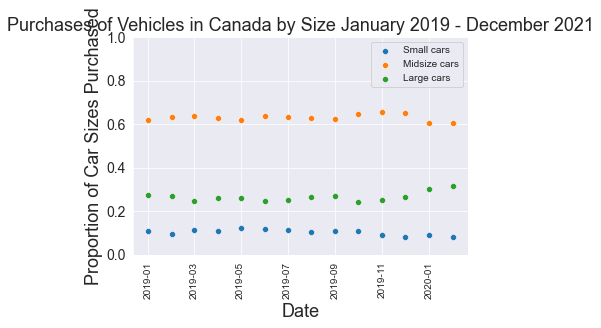

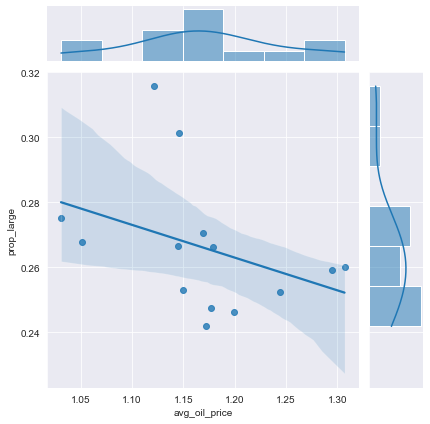

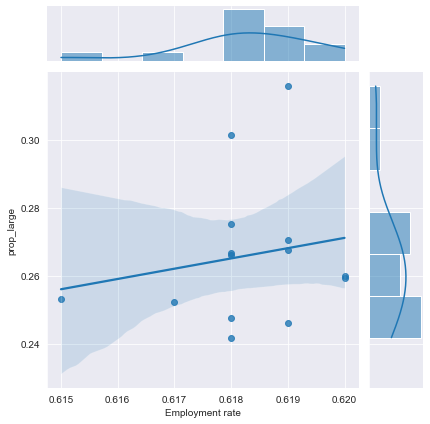

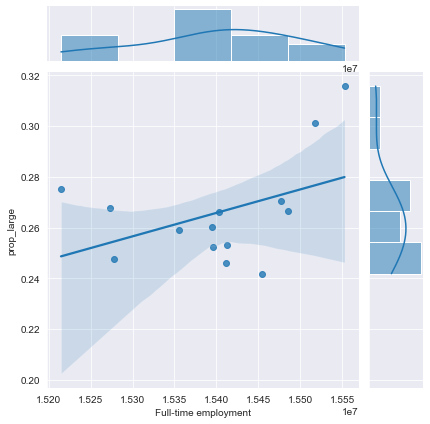

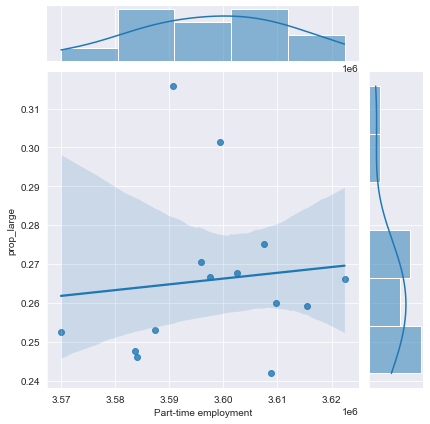

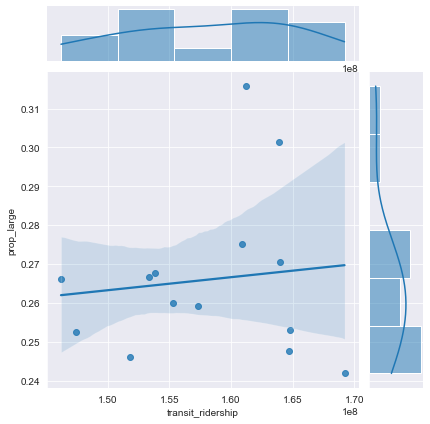

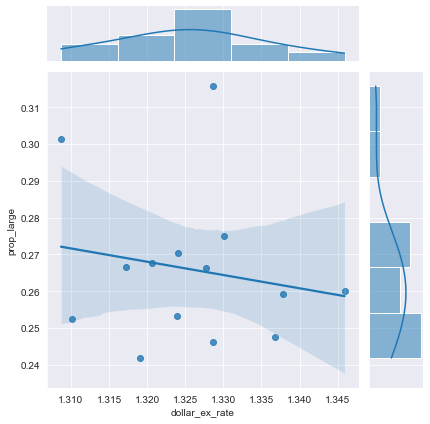

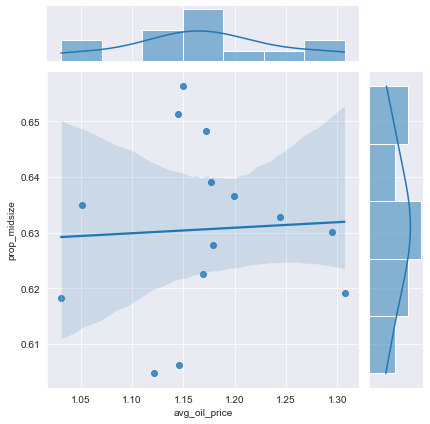

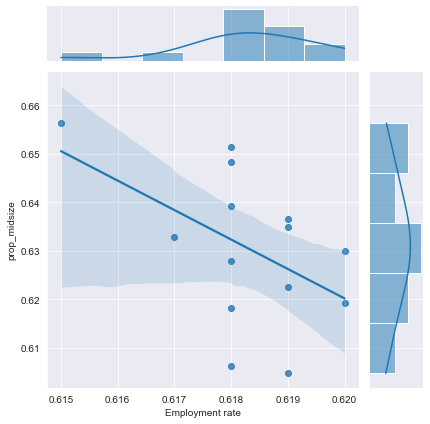

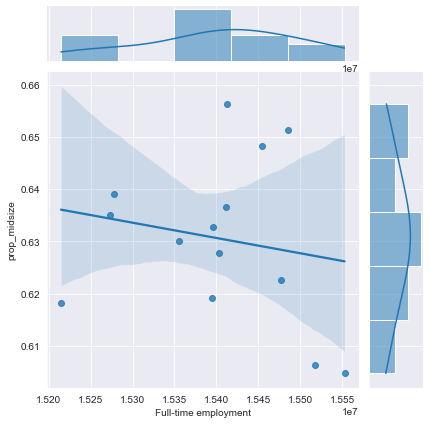

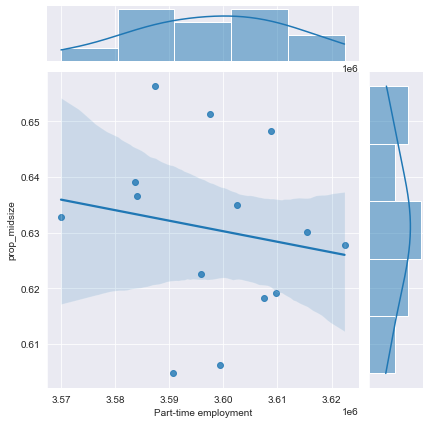

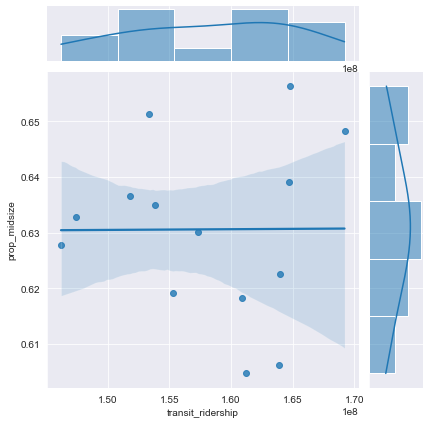

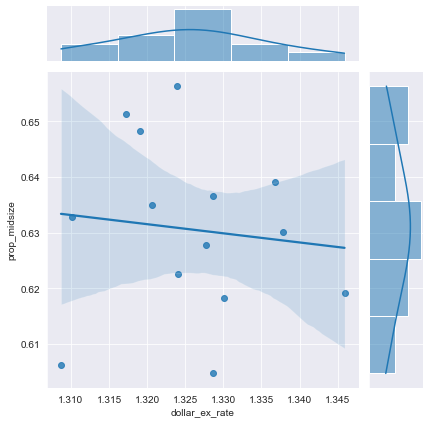

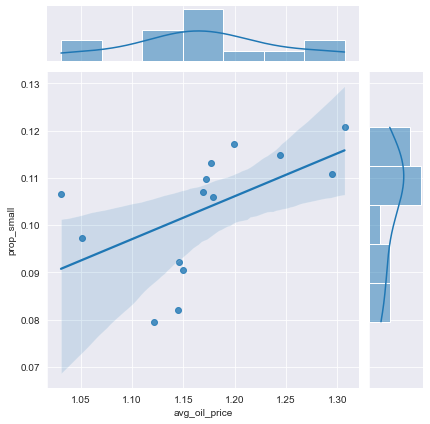

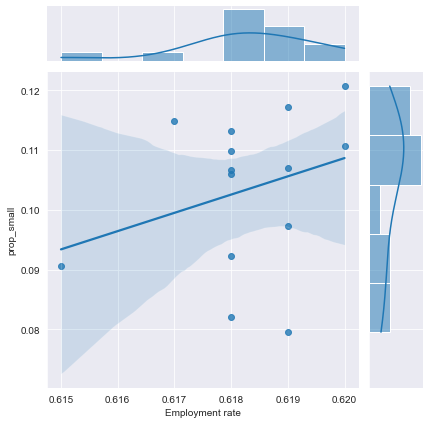

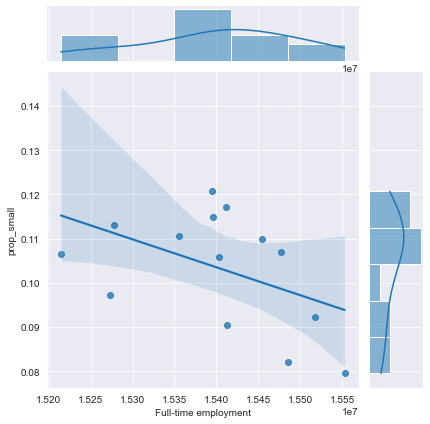

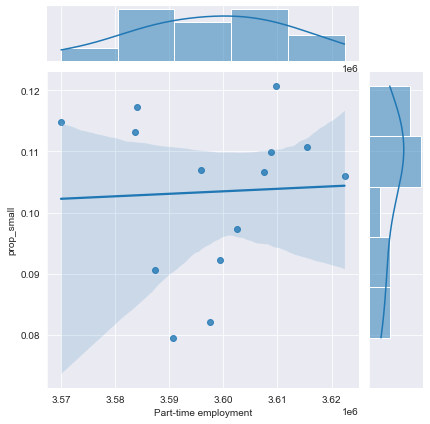

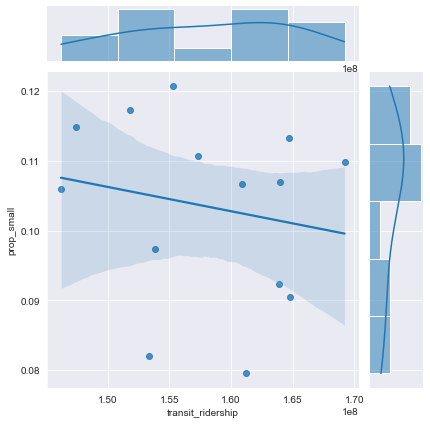

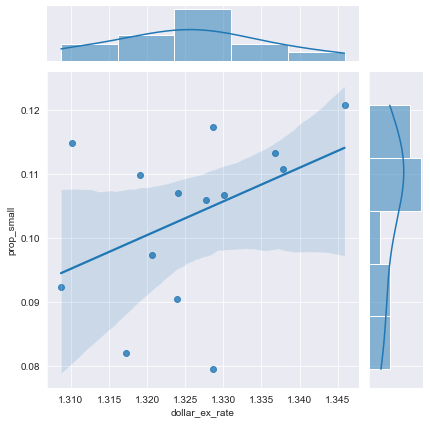

       prop_large  prop_midsize  prop_small   Population  Employment rate  \
count       14.00         14.00       14.00        14.00            14.00   
mean         0.27          0.63        0.10  30729321.43             0.62   
std          0.02          0.02        0.01    160340.73             0.00   
min          0.24          0.60        0.08  30479800.00             0.62   
25%          0.25          0.62        0.09  30599350.00             0.62   
50%          0.26          0.63        0.11  30745550.00             0.62   
75%          0.27          0.64        0.11  30864950.00             0.62   
max          0.32          0.66        0.12  30949300.00             0.62   

       Full-time employment  Part-time employment  Unemployment  \
count                 14.00                 14.00         14.00   
mean            15401957.14            3598200.00    1155235.71   
std                96340.78              14207.96      34186.47   
min             15214700.00           

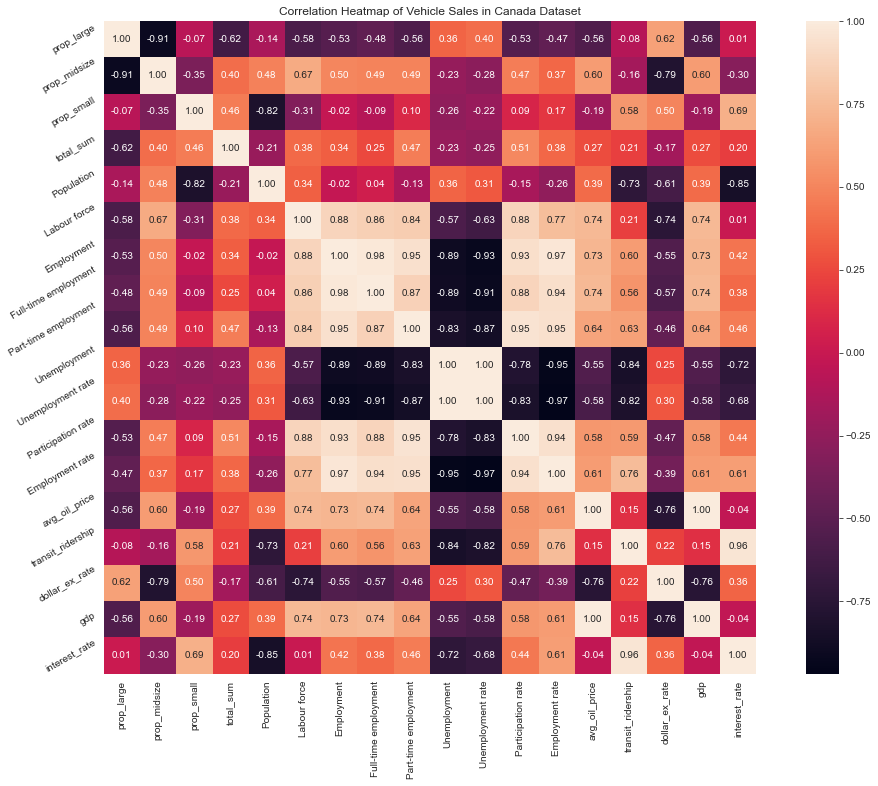

In [27]:
#Scatter plot of the purchases of small, midsize, and large vehicles
ax = sns.scatterplot(data = table_for_data_analysis, x="index", y="prop_small", label="Small cars")
ax = sns.scatterplot(data = table_for_data_analysis, x="index", y="prop_midsize", label="Midsize cars")
ax = sns.scatterplot(data = table_for_data_analysis, x="index", y="prop_large", label="Large cars")
plt.title('Purchases of Vehicles in Canada by Size January 2019 - December 2021', fontsize = 18)
ax.tick_params(axis='x', rotation=90)

#ax.xaxis.set_tick_params(labelsize = 14)
ax.yaxis.set_tick_params(labelsize = 14)
ax.set_ylim(0,1)
ax.set_xlabel('Date', fontsize = 18)
ax.set_ylabel('Proportion of Car Sizes Purchased', fontsize = 18)
ax.legend()
plt.show()

#Jointplots of oil prices, employment, population, and transit ridership with regards to vehicle sizes purchased
ax = sns.jointplot(data = table_for_data_analysis[["avg_oil_price","prop_large"]], x="avg_oil_price", y="prop_large", kind="reg")
ax = sns.jointplot(data = table_for_data_analysis[["Employment rate","prop_large"]], x="Employment rate", y="prop_large", kind="reg")
ax = sns.jointplot(data = table_for_data_analysis[["Full-time employment","prop_large"]], x="Full-time employment", y="prop_large", kind="reg")
ax = sns.jointplot(data = table_for_data_analysis[["Part-time employment","prop_large"]], x="Part-time employment", y="prop_large", kind="reg")
ax = sns.jointplot(data = table_for_data_analysis[["transit_ridership","prop_large"]], x="transit_ridership", kind="reg", y="prop_large")
ax = sns.jointplot(data = table_for_data_analysis[["dollar_ex_rate","prop_large"]], x="dollar_ex_rate", kind="reg", y="prop_large")

ax = sns.jointplot(data = table_for_data_analysis[["avg_oil_price","prop_midsize"]], x="avg_oil_price", y="prop_midsize", kind="reg")
ax = sns.jointplot(data = table_for_data_analysis[["Employment rate","prop_midsize"]], x="Employment rate", y="prop_midsize", kind="reg")
ax = sns.jointplot(data = table_for_data_analysis[["Full-time employment","prop_midsize"]], x="Full-time employment", y="prop_midsize", kind="reg")
ax = sns.jointplot(data = table_for_data_analysis[["Part-time employment","prop_midsize"]], x="Part-time employment", y="prop_midsize", kind="reg")
ax = sns.jointplot(data = table_for_data_analysis[["transit_ridership","prop_midsize"]], x="transit_ridership", y="prop_midsize", kind="reg")
ax = sns.jointplot(data = table_for_data_analysis[["dollar_ex_rate","prop_midsize"]], x="dollar_ex_rate", y="prop_midsize", kind="reg")

ax = sns.jointplot(data = table_for_data_analysis[["avg_oil_price","prop_small"]], x="avg_oil_price", y="prop_small", kind="reg")
ax = sns.jointplot(data = table_for_data_analysis[["Employment rate","prop_small"]], x="Employment rate", y="prop_small", kind="reg")
ax = sns.jointplot(data = table_for_data_analysis[["Full-time employment","prop_small"]], x="Full-time employment", y="prop_small", kind="reg")
ax = sns.jointplot(data = table_for_data_analysis[["Part-time employment","prop_small"]], x="Part-time employment", y="prop_small", kind="reg")
ax = sns.jointplot(data = table_for_data_analysis[["transit_ridership","prop_small"]], x="transit_ridership", y="prop_small", kind="reg")
ax = sns.jointplot(data = table_for_data_analysis[["dollar_ex_rate","prop_small"]], x="dollar_ex_rate", y="prop_small", kind="reg")

plt.show()

#Check for potential outliers
print(round(table_for_data_analysis.describe(),2))

#Checking for null values
print(table_for_data_analysis.isnull().sum())

#Checking correlation between variables
correlation=total_table.corr()
plt.figure(figsize=(18,12))
plt.title('Correlation Heatmap of Vehicle Sales in Canada Dataset')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)
plt.show()

#####################################################################################################################
#Since populations and transit ridership were highly correlated, these will not be included in our model

Here we develop our model

In [24]:
#Splitting data into train and test splits, taking the last 30% of the data as the test data
train_split_size = 0.7
train = total_table.iloc[0:int(len(total_table)*train_split_size),:]
test = total_table.iloc[int(len(total_table)*train_split_size):,:]

#Verify that data was split correctly
print('Train data is  {percent:.2f}% of whole dataset'.format(percent = train.shape[0] / total_table.shape[0] * 100))
print('Test data is  {percent:.2f}% of whole dataset'.format(percent = test.shape[0] / total_table.shape[0] * 100))

def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data(data):
    """Process the data for the guided model, which will predict the proportion of small, midsize, and
    large vehicles sold in Canada.
        Input: data --> dataframe with x and y values
        Output: X --> explanatory variables
                y_small --> proportion of small vehicles purchased
                y_midsize --> proportion of midsize vehicles purchased
                y_large --> proportion of large vehicles purchased
    """
    # Transform Data, Select Features
    data = select_columns(data,
                          'avg_oil_price',
                          'Full-time employment',
                          'Part-time employment',
                          'dollar_ex_rate',
                          'Employment rate',
                          'transit_ridership',
                          'interest_rate',
                          'prop_small',
                          'prop_midsize',
                          'prop_large')

    # Return predictors and response variables separately
    X = data.drop(['prop_small','prop_midsize','prop_large'], axis=1)
    y_small = data.loc[:, 'prop_small']
    y_midsize = data.loc[:, 'prop_midsize']
    y_large = data.loc[:, 'prop_large']

    return X, y_small, y_midsize, y_large

#Separating data into training, validation, and test datasets
X_train, y_train_small, y_train_midsize, y_train_large = process_data(train)
X_test, y_test_small, y_test_midsize, y_test_large = process_data(test)

#Scaling variables based on minimum and maximum values to be within 0 and 1
cols = X_train.columns
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns = cols)
X_test = pd.DataFrame(X_test, columns = cols)

#Training linear regression models for small, midsize, and large vehicle sales
linear_model_small = lm.LinearRegression(fit_intercept=True)
linear_model_midsize = lm.LinearRegression(fit_intercept=True)
linear_model_large = lm.LinearRegression(fit_intercept=True)

#time series cross validation
results = []
tscv = TimeSeriesSplit(n_splits=5)
for train_index, val_index in tscv.split(X_train):
    X_training, X_val = X_train.iloc[train_index,:], X_train.iloc[val_index,:]
    y_training_small, y_training_midsize, y_training_large = y_train_small.iloc[train_index], y_train_midsize.iloc[train_index], y_train_large.iloc[train_index]
    y_val_small, y_val_midsize, y_val_large = y_train_small.iloc[val_index], y_train_midsize.iloc[val_index], y_train_large.iloc[val_index]

    #fit the models for each fold
    linear_model_small.fit(X_training, y_training_small)
    linear_model_midsize.fit(X_training, y_training_midsize)
    linear_model_large.fit(X_training, y_training_large)

    #predict proportions based on validation dataset
    y_predicted_small = linear_model_small.predict(X_val)
    y_predicted_midsize = linear_model_midsize.predict(X_val)
    y_predicted_large = linear_model_large.predict(X_val)

    #calculate and append rmse for each fold to a results list
    results.append([mean_squared_error(y_val_small, y_predicted_small), mean_squared_error(y_val_midsize, y_predicted_midsize), mean_squared_error(y_val_large, y_predicted_large)])

#convert list of rmse's for each fold to a dataframe for easier access
errors = pd.DataFrame(results, columns = ['small', 'midsize', 'large'])

# Printing calculated error values for the validation sets of the three models
print('\n')
print('Mean Validation RMSE for small cars model: {:.2f}%'.format(errors['small'].mean()*100))
print('Mean Validation RMSE for midsize cars model: {:.2f}%'.format(errors['midsize'].mean()*100))
print('Mean Validation RMSE for large cars model: {:.2f}%'.format(errors['large'].mean()*100))
print('\n')
print('Test RMSE for small cars model: {:.2f}%'.format(mean_squared_error(y_test_small, linear_model_small.predict(X_test))*100))
print('Test RMSE for midsize cars model: {:.2f}%'.format(mean_squared_error(y_test_midsize, linear_model_small.predict(X_test))*100))
print('Test RMSE for large cars model: {:.2f}%'.format(mean_squared_error(y_test_large, linear_model_small.predict(X_test))*100))

Train data is  69.44% of whole dataset
Test data is  30.56% of whole dataset


Mean Validation RMSE for small cars model: 0.07%
Mean Validation RMSE for midsize cars model: 7.14%
Mean Validation RMSE for large cars model: 6.93%


Test RMSE for small cars model: 0.25%
Test RMSE for midsize cars model: 31.04%
Test RMSE for large cars model: 1.63%
